# Analyze and classify images

In [1]:
# Created by Jesús García García - Master´s Degree in Big Data Analytics UEM

In [2]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC




# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


Extracting the top 150 eigenfaces from 966 faces
done in 0.107s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.018s
Fitting the classifier to the training set
done in 24.350s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.045s
                   precision    recall  f1-score   support

     Ariel Sharon       0.57      0.62      0.59        13
     Colin Powell       0.74      0.85      0.79        60
  Donald Rumsfeld       0.72      0.78      0.75        27
    George W Bush       0.89      0.86      0.88       146
Gerhard Schroeder       0.80      0.80      0.80        25
      Hugo Chavez       0.67      0.53      0.59        15
       Tony Blair       0.84      0.75      0.79        36

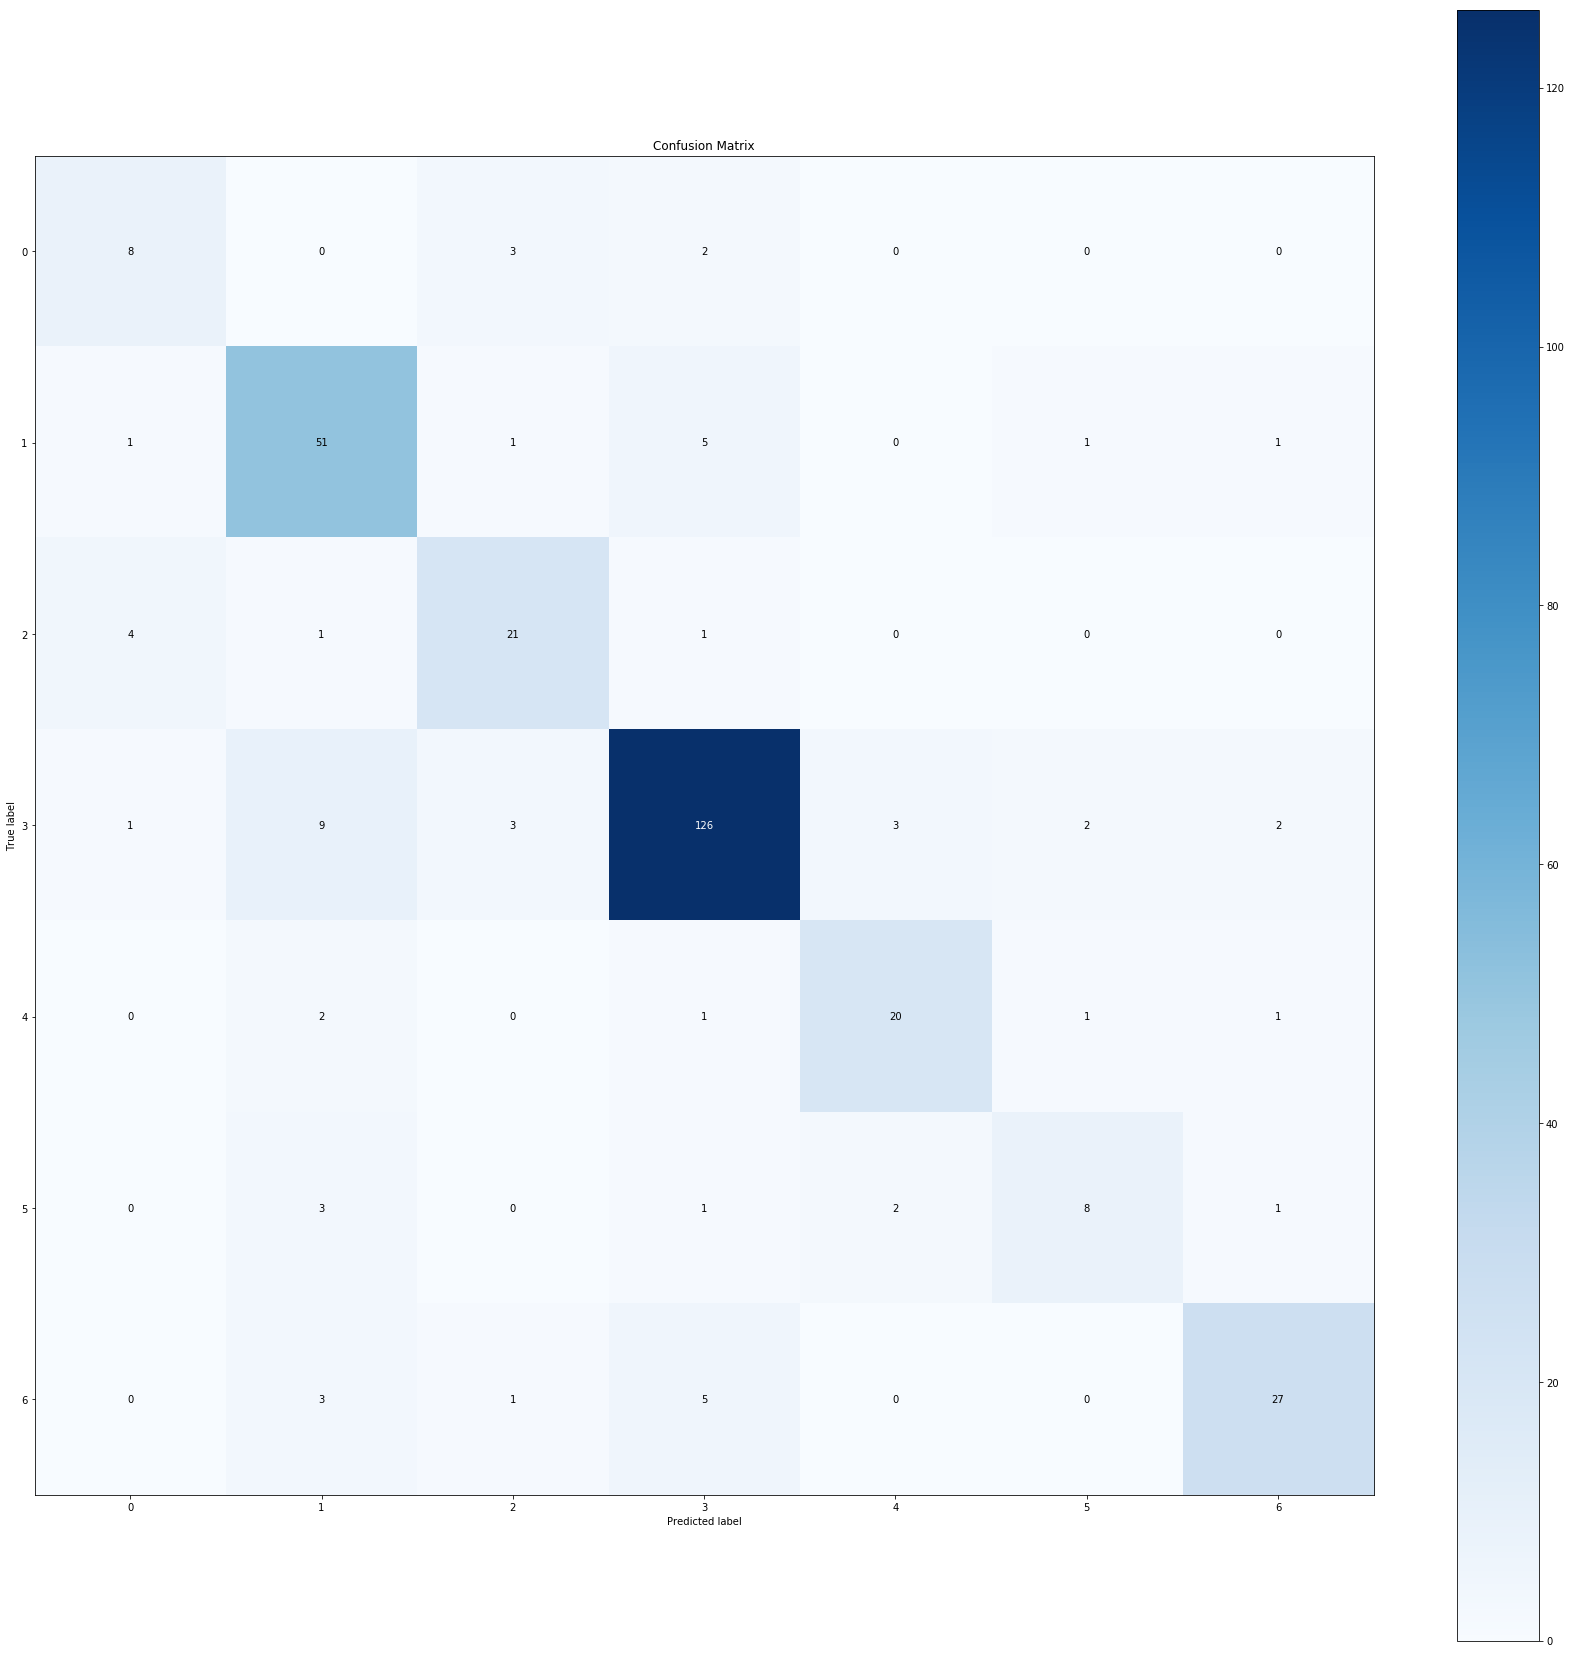

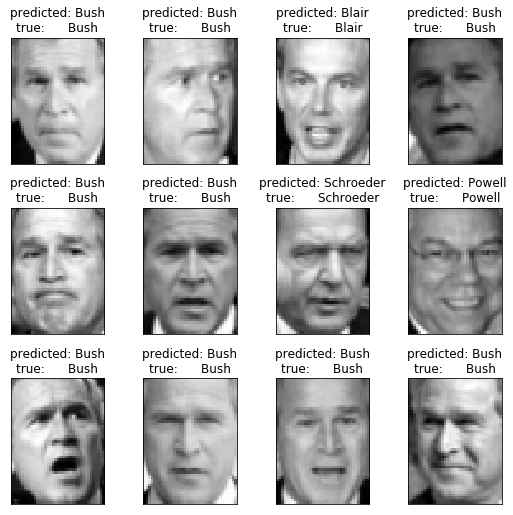

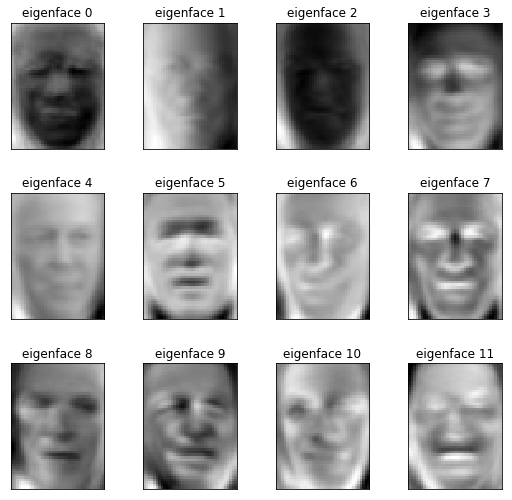

In [4]:
# #############################################################################
# Split into a training set and a test set using a stratified k fold

#Train and Test. Use SciKit Learn to create training and testing sets of the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

#Print Evaluation (classification report)
print(classification_report(y_test, y_pred, target_names=target_names))



#Print confusion matrix
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size
plt.show()

# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [5]:
#Use MLP applying TensorFlow
#Show X data and type
X.dtype
X

array([[ 254.        ,  254.        ,  251.66667175, ...,   87.33333588,
          88.66666412,   86.66666412],
       [  39.66666794,   50.33333206,   47.        , ...,  117.66666412,
         115.        ,  133.66667175],
       [  89.33333588,  104.        ,  126.        , ...,  175.33332825,
         183.33332825,  183.        ],
       ..., 
       [  86.        ,   80.33333588,   74.66666412, ...,   44.        ,
          49.66666794,   44.66666794],
       [  50.33333206,   65.66666412,   88.        , ...,  197.        ,
         179.33332825,  166.33332825],
       [  30.        ,   27.        ,   32.66666794, ...,   35.        ,
          35.33333206,   61.        ]], dtype=float32)

In [6]:
#Show y data and type
y.dtype
y

array([5, 6, 3, ..., 5, 3, 5], dtype=int64)

In [7]:
#Train and Test. Use SciKit Learn to create training and testing sets of the data
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
#Contrib.learn
#Import tensorflow.contrib.learn as learn
import tensorflow as tf
import tensorflow.contrib.learn as learn

2018-04-20 01:25:15,036 From C:\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.


In [9]:
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=1)]
#Create an object called classifier which is a DNNClassifier from learn. Set it to have 2 classes and a [10,20,10] hidden unit layer structure:
classifier = learn.DNNClassifier(feature_columns=feature_columns, hidden_units=[10, 20, 10], n_classes=2)

2018-04-20 01:25:30,239 From C:\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\dnn.py:378: multi_class_head (from tensorflow.contrib.learn.python.learn.estimators.head) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
2018-04-20 01:25:30,256 From C:\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\estimator.py:1165: BaseEstimator.__init__ (from tensorflow.contrib.learn.python.learn.estimators.estimator) is deprecated and will be removed in a future version.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
2018-04-20 01:25:30,278 From C:\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\estimator.py:427: RunConfig.__init__ (from tensorflow.contrib.learn.python.learn.estimators.run_config) is deprecated and will be removed in a future version.
Instructi

In [10]:
#Fit classifier to the training data. Use steps=200 with a batch_size of 20.
classifier.fit(X_train, y_train, steps=200, batch_size=20)

2018-04-20 01:25:34,482 From <ipython-input-10-0b35a3b2b9d1>:2: calling BaseEstimator.fit (from tensorflow.contrib.learn.python.learn.estimators.estimator) with x is deprecated and will be removed after 2016-12-01.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
2018-04-20 01:25:34,502 From <ipython-input-10-0b35a3b2b9d1>:2: calling BaseEstimator.fit (from tensorflow.contrib.learn.python.learn.estimators.estimator) with y is deprecated and will be removed after 2016-12-01.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(.

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x0000022D22639470>, 'hidden_units': [10, 20, 10], 'feature_columns': (_RealValuedColumn(column_name='', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x0000022D1A2AC158>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [11]:
#Model Evaluation
#Use the predict method from the classifier model to create predictions from X_test
note_predictions = classifier.predict(X_test, as_iterable=False)

2018-04-20 01:25:46,868 From <ipython-input-11-65f734391ab4>:3: calling DNNClassifier.predict (from tensorflow.contrib.learn.python.learn.estimators.dnn) with as_iterable=False is deprecated and will be removed after 2016-09-15.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
2018-04-20 01:25:46,894 From C:\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py:497: calling DNNClassifier.predict (from tensorflow.contrib.learn.python.learn.estimators.dnn) with outputs=None is deprecated and will be removed after 2017-03-01.
Instructions for updating:
Please switch to predict_classes, or set `outputs` argument.
2018-04-20 01:25:46,924 From C:\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\dnn.py:427: calling DNNClassifier.predict_classes (from tensorflow.contrib.learn.python.le

In [12]:
#Print all generator expression
print(list(note_predictions))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


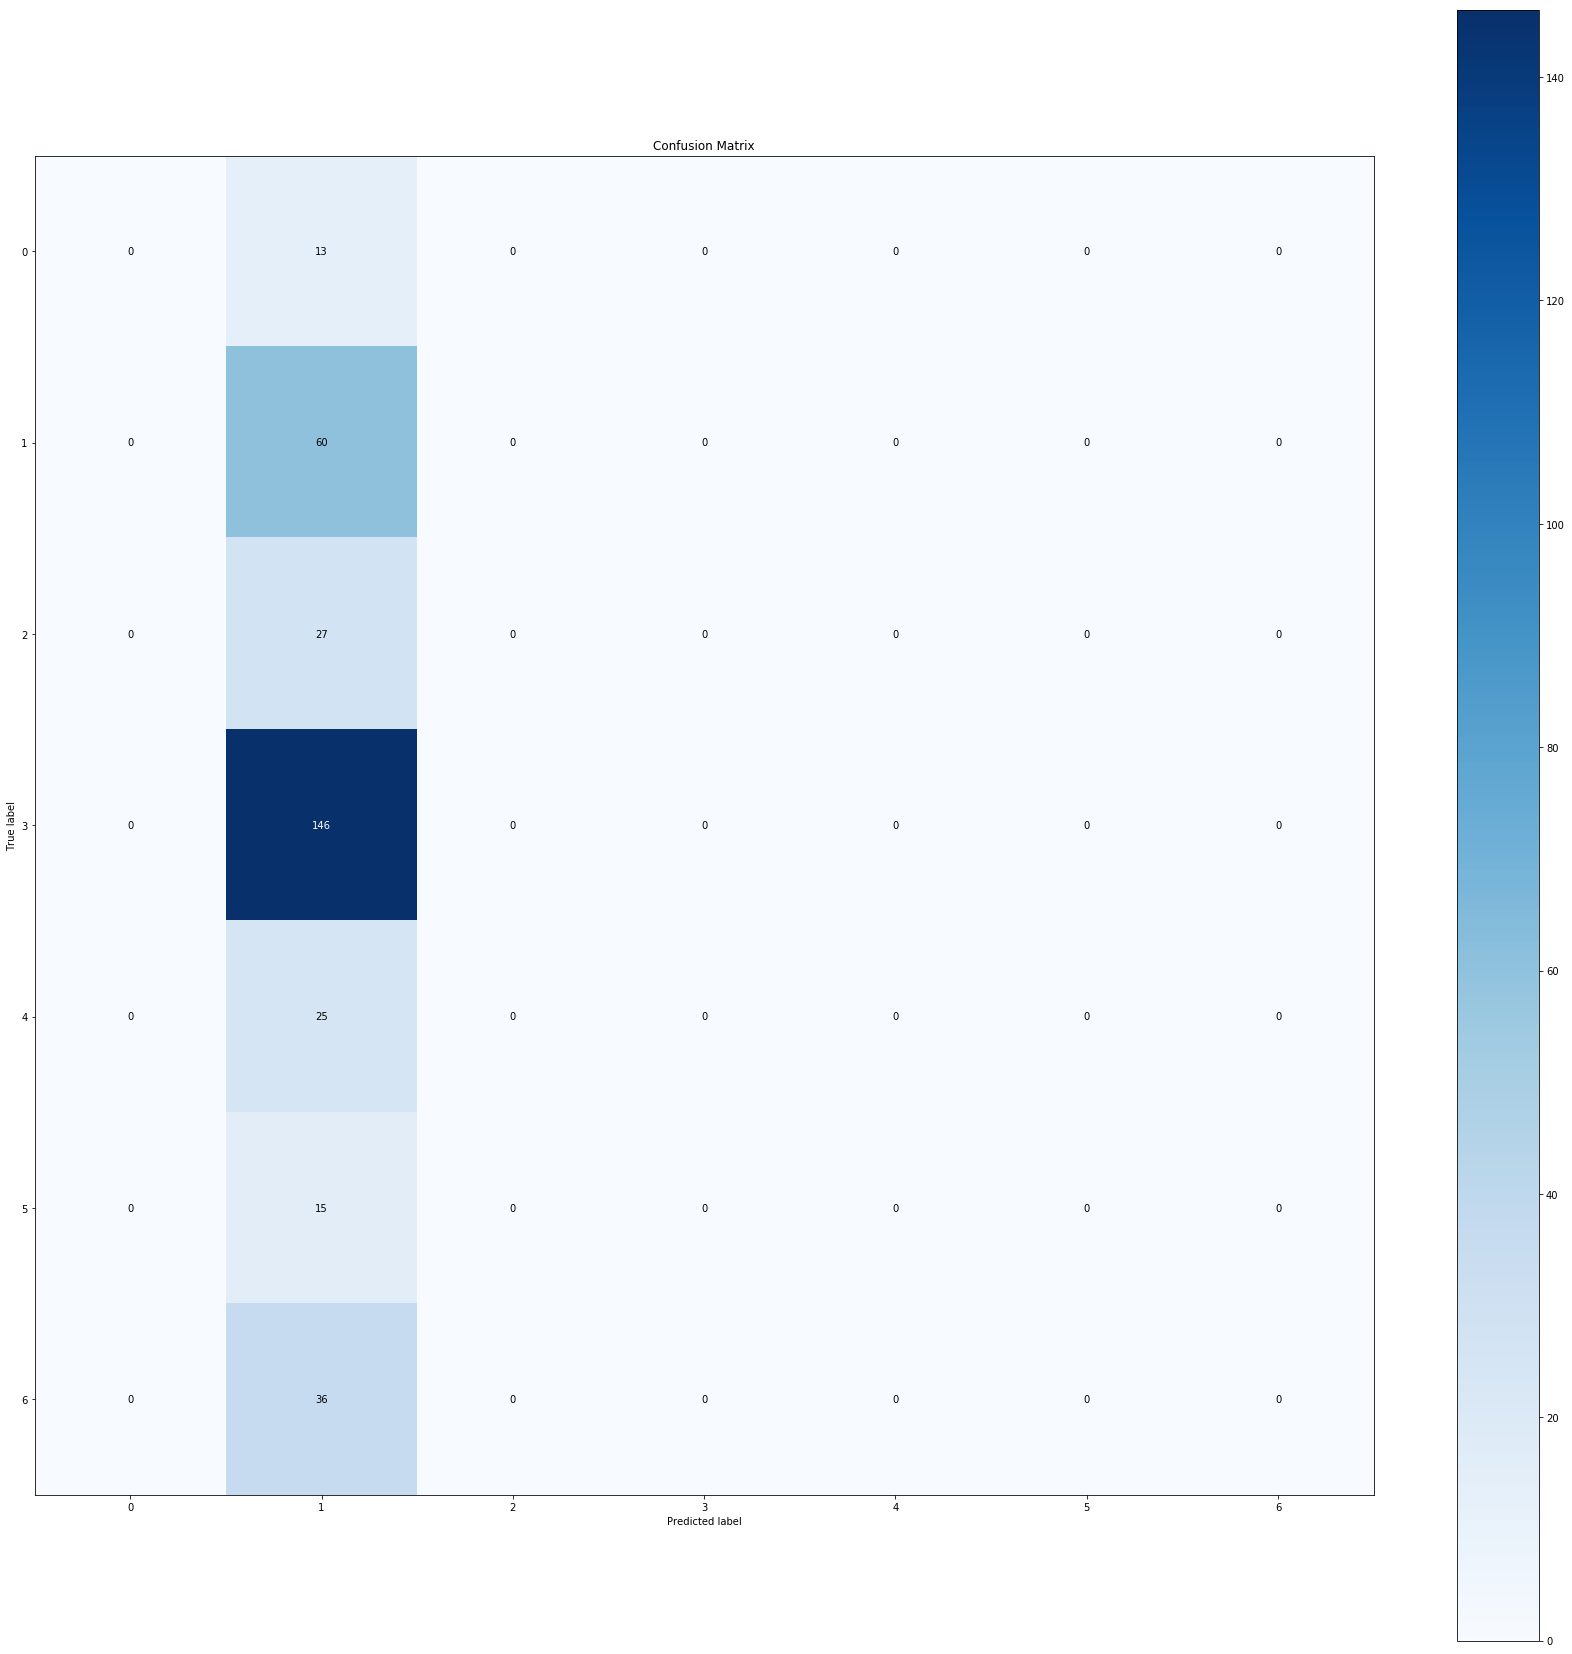

TensorFlow Accuracy: 0.186335


In [13]:
#Print confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn import datasets
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test, note_predictions, normalize=False)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size
plt.show()

#Print score
score = metrics.accuracy_score(y_test, note_predictions)
print('TensorFlow Accuracy: {0:f}'.format(score))

In [14]:
#Print Evaluation (classification report)
print(classification_report(y_test,note_predictions, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.19      1.00      0.31        60
  Donald Rumsfeld       0.00      0.00      0.00        27
    George W Bush       0.00      0.00      0.00       146
Gerhard Schroeder       0.00      0.00      0.00        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.00      0.00      0.00        36

      avg / total       0.03      0.19      0.06       322



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
